# STEP 1

In [484]:
"""
Load the dataset
"""

import numpy as np

data = np.loadtxt('wifi_db/clean_dataset.txt')
# data = np.loadtxt('wifi_db/noisy_dataset.txt')

# STEP 2

In [485]:
def entropy(dataset):
    _, counts = np.unique(dataset[:,-1], return_counts=True)
    ps = counts / dataset.shape[0]

    return -np.sum(ps * np.log2(ps))

entropy(data)

np.float64(2.0)

In [486]:
def remainder(s_left, s_right):
    """
    Computes the remainder (weighted entropy) for a potential split in a dataset during decision tree construction. 
    
    This is used to evaluate the quality of
    the split by calculating the entropy on both sides of the split.
    """

    # Calculate the number of samples in each subset
    n_left = s_left.shape[0]
    n_right = s_right.shape[0]

    return (n_left * entropy(s_left) + n_right * entropy(s_right)) / (n_left + n_right)

In [487]:
def info_gain(all, left, right):
    """
    Computes the information gain from a potential split in the dataset during decision tree construction.
    """
    
    return entropy(all) - remainder(left, right)

In [488]:
def find_split(dataset):
    """
    Finds the optimal feature and threshold to split the dataset during decision tree construction by maximizing the information gain. 
    
    The function evaluates all possible splits and selects the one that yields the highest 
    reduction in entropy.
    """

    num_features = dataset[:, :-1].shape[1]

    max_feature = -1
    max_gain = -1
    max_left = -1
    max_right = -1
    for feature in range(num_features):
        # Sort the data on the specified feature
        sorted_data = dataset[dataset[:, feature].argsort()]
        features = sorted_data[:, :-1]
        labels = sorted_data[:, -1]

        # Iterate through the sorted data until have found a "split point"
        for point in range(len(features) - 1):
            if labels[point] == labels[point + 1]:
                continue

            left = sorted_data[:point + 1, :]
            right = sorted_data[point + 1:, :]
            
            # Calculate the information gain for this split
            curr_gain = info_gain(sorted_data, left, right)
         
            # If this is the best split so far, update the best split
            if curr_gain > max_gain:
                max_gain = curr_gain
                max_feature = feature
                max_left = left
                max_right = right


    return {'feature': max_feature, 'threshold': max_right[0, max_feature], 'left': max_left, 'right': max_right}

In [505]:
def build_decision_tree(dataset, depth=1):
    labels = dataset[:, -1]

    if len(np.unique(labels)) == 1:
        return {'value': labels[0]}, depth
            
    # Find the best split to maximise the information gain
    split = find_split(dataset)

    l_branch, l_depth = build_decision_tree(split['left'], depth + 1)
    r_branch, r_depth = build_decision_tree(split['right'], depth + 1)

    node = {'feature': split['feature'], 'value': split['threshold'], 'left': l_branch, 'right': r_branch}

    return node, max(l_depth, r_depth)

# build_decision_tree(data)

({'feature': 0,
  'value': np.float64(-55.0),
  'left': {'feature': 4,
   'value': np.float64(-59.0),
   'left': {'feature': 3,
    'value': np.float64(-56.0),
    'left': {'feature': 4,
     'value': np.float64(-64.0),
     'left': {'value': np.float64(1.0)},
     'right': {'feature': 6,
      'value': np.float64(-85.0),
      'left': {'feature': 1,
       'value': np.float64(-55.0),
       'left': {'value': np.float64(1.0)},
       'right': {'feature': 0,
        'value': np.float64(-56.0),
        'left': {'value': np.float64(4.0)},
        'right': {'value': np.float64(3.0)}}},
      'right': {'value': np.float64(1.0)}}},
    'right': {'feature': 0,
     'value': np.float64(-57.0),
     'left': {'feature': 2,
      'value': np.float64(-51.0),
      'left': {'value': np.float64(1.0)},
      'right': {'feature': 0,
       'value': np.float64(-58.0),
       'left': {'value': np.float64(3.0)},
       'right': {'value': np.float64(4.0)}}},
     'right': {'value': np.float64(3.0)}}},
   

In [490]:
def layout(tree, depth) -> tuple[list, list]:
    """
    Function to determine the coordinates of the nodes and arrows in the decision tree.
    """
    
    points = [] # [(x,y, attribute, value)]
    arrows = [] # [((x1,y1), (x2,y2))]

    def dfs(tree, x, y):
        if not tree:
            return
        
        if not 'left' in tree and not 'right' in tree:
            points.append((x, y, None, tree['value'] ))
            return
        
        points.append((x, y, tree['feature'], tree['value']))
        offset_x = 2 ** (depth - y - 2)
        
        # Calculate the x coordinates of the left and right children
        left_x = x - offset_x
        right_x = x + offset_x

        arrows.append(((x, y), (left_x, y + 1)))
        arrows.append(((x, y), (right_x, y + 1)))

        dfs(tree['left'], left_x, y + 1)
        dfs(tree['right'], right_x, y + 1)

    dfs(tree, 2**(depth - 1) - 1, 0)

    return points, arrows

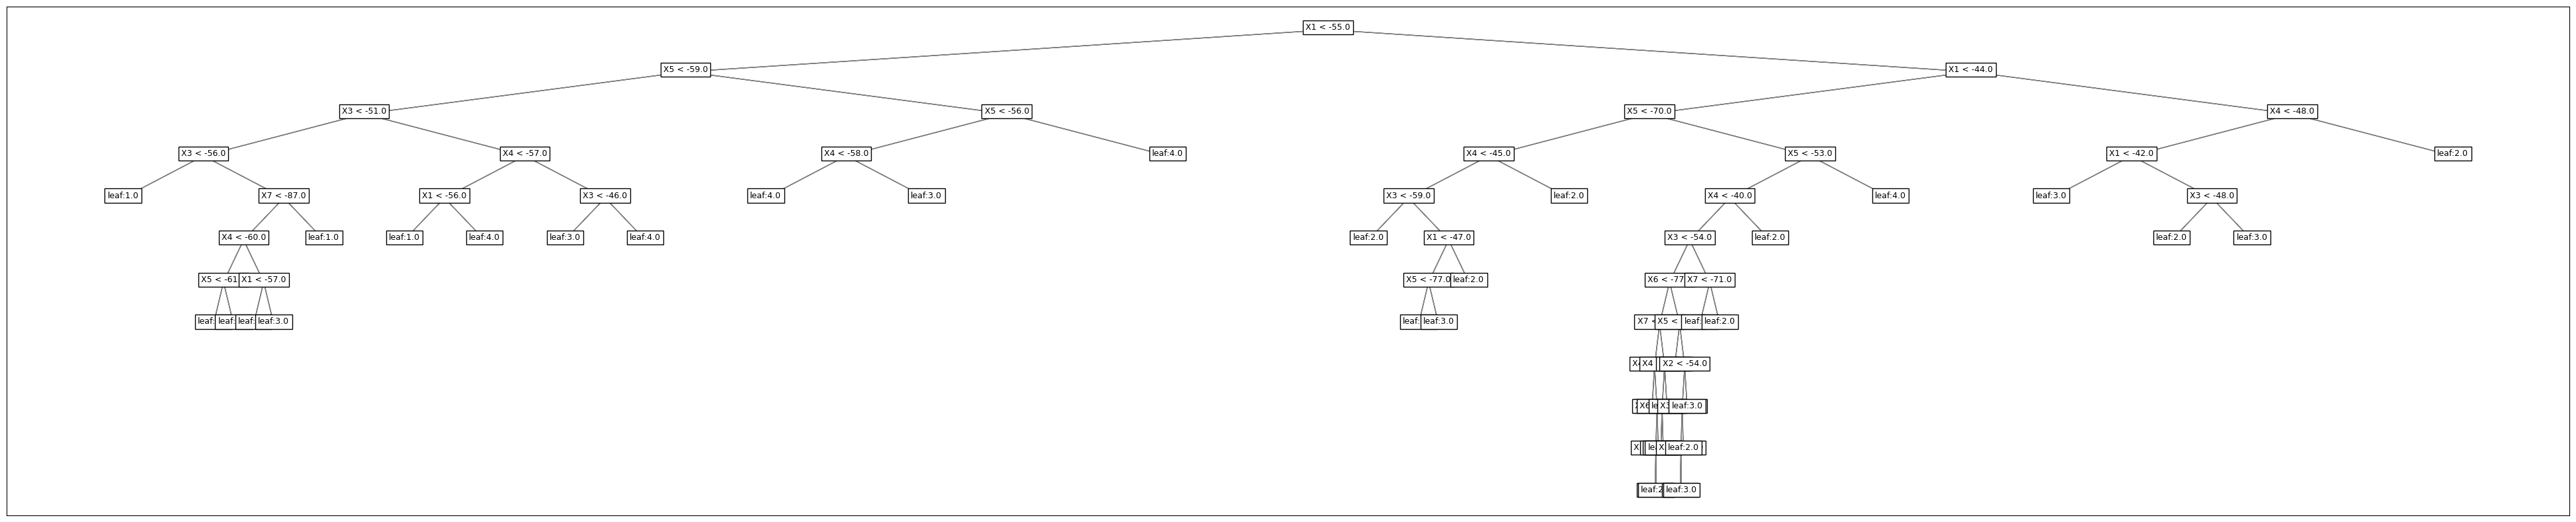

In [504]:
import matplotlib.pyplot as plt

def plot_node_texts(x_coords, y_coords, features, values):
    """
    Plot the text annotations for each node in the decision tree.
    """
    for i, value in enumerate(values):
        if features[i] is None:
            plt.text(
                x_coords[i], y_coords[i], f'leaf:{value}', 
                fontsize=9, ha='center', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}
            )
        else:
            plt.text(
                x_coords[i], y_coords[i], f'X{features[i]+1} < {value}', 
                fontsize=9, ha='center', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}
            )

def plot_arrows(arrows):
    """
    Draw the arrows connecting the nodes in the decision tree.
    """
    for start, end in arrows:
        x_start, y_start = start[0], -start[1]
        x_end, y_end = end[0], -end[1]

        plt.arrow(
            x_start, y_start, x_end - x_start, y_end - y_start,
            head_width=0, head_length=0, fc='gray', ec='gray', 
            length_includes_head=True
        )

def draw_tree(nodes, arrows):
    """
    Function to draw the decision tree.
    """

    x_coords = [point[0] for point in nodes]
    y_coords = [-point[1] for point in nodes]
    features = [point[2] for point in nodes]
    values = [point[3] for point in nodes]

    plt.figure(figsize=(50, 10))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    # Plot arrows and node labels
    plot_node_texts(x_coords, y_coords, features, values)
    plot_arrows(arrows)
  
    plt.grid(True)
    plt.show()

draw_tree(*layout(*build_decision_tree(data)))

# STEP 3

In [492]:
def traverse_singular(tree, entry) -> int:
    """
    Function to traverse the decision tree and make a prediction for a single entry.
    """

    if 'left' not in tree and 'right' not in tree:
        return tree['value']
    
    if entry[tree['feature']] < tree['value']:
        return traverse_singular(tree['left'], entry)
    
    return traverse_singular(tree['right'], entry)

In [493]:
def single_confusion_matrix_for(tree, data):
    """
    Calculates the confusion matrix for a decision tree on a dataset.
    """  

    confusion_matrix = np.zeros((4,4), dtype=int)

    for entry in data:
        predicted = traverse_singular(tree, entry)
        actual = entry[-1]

        confusion_matrix[int(actual - 1)][int(predicted - 1)] += 1

    return confusion_matrix

In [494]:
num_matrix_splits = 10

def confusion_matrix_for(data):
    """
    Compute the confusion matrix for the decision tree on the dataset
    """

    # Split the data into 10 folds
    np.random.shuffle(data)

    split_size = len(data) // num_matrix_splits
    num_unique_labels = np.unique(data[:,-1]).shape[0]

    confusion_matrix = np.zeros((num_unique_labels,num_unique_labels), dtype=int)
    cm_splits = [] # List of confusion matrices for each split

    for i in range(num_matrix_splits):
        # Split the data into training and testing sets
        left = data[:i * split_size]
        test = data[i * split_size: (i+1) * split_size]
        right = data[(i+1) * split_size + num_matrix_splits:]

        # Build the decision tree on the training set
        train = np.concatenate((left, right), axis=0)
        tree, _ = build_decision_tree(train)

        # Compute the confusion matrix for the test set
        cm = single_confusion_matrix_for(tree, test)
        confusion_matrix += cm
        cm_splits.append(cm)

    return confusion_matrix, cm_splits

cm, cm_splits = confusion_matrix_for(data)
print(cm)

[[490   0   4   6]
 [  0 482  18   0]
 [  2  23 472   3]
 [  4   0   5 491]]


In [495]:
def accuracy(confusion_matrix):
    total = np.sum(confusion_matrix)
    correct = np.sum(np.diagonal(confusion_matrix))

    return float(correct / total)

print(f'accuracy: {accuracy(cm)}')

accuracy: 0.9675


In [496]:
def precision_for_label(label, confusion_matrix):
    tp = confusion_matrix[label - 1][label - 1]
    fp = 0
    for i in range(4):
        if i+1 == label:
            continue
        fp += confusion_matrix[i][label - 1]

    return float(tp / (tp + fp))

In [497]:
def macro_averaged_precision(cms, label):
    sum = 0
    for cm in cms:
        sum += precision_for_label(label, cm)
    return sum / len(cms)

for i in range(4):
    print(f'macro_averaged_precision X{i+1}: {macro_averaged_precision(cm_splits, i+1)}')

macro_averaged_precision X1: 0.9876426505600369
macro_averaged_precision X2: 0.9552915026486017
macro_averaged_precision X3: 0.9473019231479956
macro_averaged_precision X4: 0.9810932113495332


In [498]:
def recall_for_label(label, confusion_matrix):
    tp = confusion_matrix[label - 1][label - 1]
    fn = 0
    for i in range(4):
        if i+1 == label:
            continue
        fn += confusion_matrix[label - 1][i]

    return float(tp / (tp + fn))

In [499]:
def macro_averaged_recall_for_label(label, confusion_matrices):
    sum = 0
    for cm in confusion_matrices:
        sum += recall_for_label(label, cm)
    return sum / len(confusion_matrices)

for i in range(4):
    print(f'macro_averaged_recall X{i+1}: {macro_averaged_recall_for_label(i+1, cm_splits)}')

macro_averaged_recall X1: 0.9801578888219028
macro_averaged_recall X2: 0.9644352532014256
macro_averaged_recall X3: 0.9431126522323254
macro_averaged_recall X4: 0.9814504888703972


In [500]:
def f1(cm, label):
    p = precision_for_label(cm, label)
    r = recall_for_label(cm, label)
    return (2 * p * r) / (p + r)

In [501]:
def macro_averaged_f1_for_label(label, confusion_matrices):
    """
    Compute the macro-averaged F1 measure for a given label.
    """
    
    sum = 0
    for cm in confusion_matrices:
        sum += recall_for_label(label, cm)
    return sum / len(confusion_matrices)

for i in range(4):
    print(f'macro_averaged_f1_measure X{i+1}: {macro_averaged_f1_for_label(i+1, cm_splits)}')

macro_averaged_f1_measure X1: 0.9801578888219028
macro_averaged_f1_measure X2: 0.9644352532014256
macro_averaged_f1_measure X3: 0.9431126522323254
macro_averaged_f1_measure X4: 0.9814504888703972
